In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import xgboost as xgb 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime

1. Load the csv file in.

In [2]:
aqiDF = pd.read_csv('aqi_ny.csv')

In [3]:
aqiDF

,Unnamed: 0,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


2. Drop the extra index.

In [4]:
aqiDF = aqiDF.drop('Unnamed: 0', axis=1)

In [5]:
aqiDF

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


3. Trying to predict values mainly on time, so get rid of extra columns other than date and what we are trying to predict, PM2.5. 

In [7]:
df = aqiDF[['date', 'pm2_5']]

In [8]:
df

,date,pm2_5
0,2020-12-01 05:00:00,9.31
1,2020-12-01 06:00:00,8.43
2,2020-12-01 07:00:00,8.55
3,2020-12-01 08:00:00,8.92
4,2020-12-01 09:00:00,9.62
...,...,...
18056,2022-12-31 13:00:00,36.08
18057,2022-12-31 14:00:00,45.75
18058,2022-12-31 15:00:00,50.21
18059,2022-12-31 16:00:00,48.14


4. Make the date column the index, and change it to datetime.

In [9]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [10]:
df

,pm2_5
date,
2020-12-01 05:00:00,9.31
2020-12-01 06:00:00,8.43
2020-12-01 07:00:00,8.55
2020-12-01 08:00:00,8.92
2020-12-01 09:00:00,9.62
...,...
2022-12-31 13:00:00,36.08
2022-12-31 14:00:00,45.75
2022-12-31 15:00:00,50.21


5. Split the data into training and testing data, roughly a 75/25 split. In this case, I did it based on date because you want to make sure the data stays consecutive. 

In [11]:
train = df.loc[df.index < '2022-07-01']
test = df.loc[df.index >= '2022-07-01']

6. Visualization of the training versus testing data.

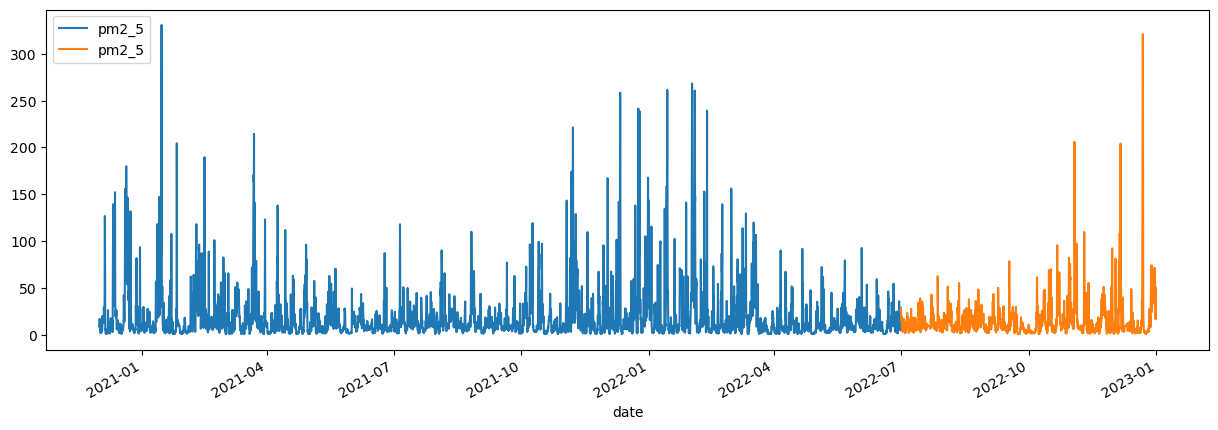

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label='Test Set')
plt.show()

In [13]:
train 

,pm2_5
date,
2020-12-01 05:00:00,9.31
2020-12-01 06:00:00,8.43
2020-12-01 07:00:00,8.55
2020-12-01 08:00:00,8.92
2020-12-01 09:00:00,9.62
...,...
2022-06-30 19:00:00,5.07
2022-06-30 20:00:00,8.95
2022-06-30 21:00:00,20.33


In [14]:
test

,pm2_5
date,
2022-07-01 00:00:00,27.85
2022-07-01 01:00:00,26.29
2022-07-01 02:00:00,25.40
2022-07-01 03:00:00,25.88
2022-07-01 04:00:00,25.46
...,...
2022-12-31 13:00:00,36.08
2022-12-31 14:00:00,45.75
2022-12-31 15:00:00,50.21


7. Machine Learning Models are not typically used on time series data, but XGBoost is considered one of the best models to use if you want to use a ML model to predict time series data. The model does not understand time, so you have to add features so that it gets a sense of how the data changes with time. To do this, I added extra feature columns that say what hour of the day, day of the week, and week of the year the row of data comes from. 

In [28]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df


df = create_features(df)
test = create_features(test)
train = create_features(train)

8. I also added three columns of lag features, which show the data for the last three hours in each row. 

In [36]:
def add_lags(df):
    target_map = df['pm2_5'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 hour')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 hours')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 hours')).map(target_map)
    return df

In [37]:
df = add_lags(df)
test = add_lags(test)
train = add_lags(train)

In [39]:
train 

,pm2_5,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
date,,,,,,,,,,
2020-12-01 05:00:00,9.31,5,1,4,12,2020,336,NaN,NaN,NaN
2020-12-01 06:00:00,8.43,6,1,4,12,2020,336,9.31,NaN,NaN
2020-12-01 07:00:00,8.55,7,1,4,12,2020,336,8.43,9.31,NaN
2020-12-01 08:00:00,8.92,8,1,4,12,2020,336,8.55,8.43,9.31
2020-12-01 09:00:00,9.62,9,1,4,12,2020,336,8.92,8.55,8.43
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,5.07,19,3,2,6,2022,181,4.52,4.97,7.41
2022-06-30 20:00:00,8.95,20,3,2,6,2022,181,5.07,4.52,4.97
2022-06-30 21:00:00,20.33,21,3,2,6,2022,181,8.95,5.07,4.52


In [40]:
df

,pm2_5,lag1,lag2,lag3,hour,dayofweek,quarter,month,year,dayofyear
date,,,,,,,,,,
2020-12-01 05:00:00,9.31,NaN,NaN,NaN,5,1,4,12,2020,336
2020-12-01 06:00:00,8.43,9.31,NaN,NaN,6,1,4,12,2020,336
2020-12-01 07:00:00,8.55,8.43,9.31,NaN,7,1,4,12,2020,336
2020-12-01 08:00:00,8.92,8.55,8.43,9.31,8,1,4,12,2020,336
2020-12-01 09:00:00,9.62,8.92,8.55,8.43,9,1,4,12,2020,336
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,24.86,17.82,16.50,13,5,4,12,2022,365
2022-12-31 14:00:00,45.75,36.08,24.86,17.82,14,5,4,12,2022,365
2022-12-31 15:00:00,50.21,45.75,36.08,24.86,15,5,4,12,2022,365


In [35]:
test

,pm2_5,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
date,,,,,,,,,,
2022-07-01 00:00:00,27.85,0,4,3,7,2022,182,NaN,NaN,NaN
2022-07-01 01:00:00,26.29,1,4,3,7,2022,182,NaN,NaN,NaN
2022-07-01 02:00:00,25.40,2,4,3,7,2022,182,NaN,NaN,NaN
2022-07-01 03:00:00,25.88,3,4,3,7,2022,182,NaN,NaN,NaN
2022-07-01 04:00:00,25.46,4,4,3,7,2022,182,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,13,5,4,12,2022,365,65.47,55.95,73.07
2022-12-31 14:00:00,45.75,14,5,4,12,2022,365,71.34,58.88,72.61
2022-12-31 15:00:00,50.21,15,5,4,12,2022,365,69.63,54.96,62.63


9. Separate what you are trying to predict from your predictors, and do that for both the training and testing data. 

In [41]:
features = ['hour','dayofweek','quarter','month','year','dayofyear', 'lag1', 'lag2', 'lag3']
target = 'pm2_5'

In [42]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

10. Create the model, which includes instantiating and fitting the model. The number of trees is high so the learning rate has to be low, the model also stops early if it is not improving. 

In [43]:
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                       learning_rate=.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:30.69360	validation_1-rmse:25.32290
[1]	validation_0-rmse:30.66467	validation_1-rmse:25.29969
[2]	validation_0-rmse:30.63578	validation_1-rmse:25.27650
[3]	validation_0-rmse:30.60692	validation_1-rmse:25.25333
[4]	validation_0-rmse:30.57809	validation_1-rmse:25.23020
[5]	validation_0-rmse:30.54928	validation_1-rmse:25.20708
[6]	validation_0-rmse:30.52051	validation_1-rmse:25.18399
[7]	validation_0-rmse:30.49177	validation_1-rmse:25.16092
[8]	validation_0-rmse:30.46305	validation_1-rmse:25.13787
[9]	validation_0-rmse:30.43437	validation_1-rmse:25.11484
[10]	validation_0-rmse:30.40571	validation_1-rmse:25.09185
[11]	validation_0-rmse:30.37709	validation_1-rmse:25.06887
[12]	validation_0-rmse:30.34849	validation_1-rmse:25.04592
[13]	validation_0-rmse:30.31993	validation_1-rmse:25.02300
[14]	validation_0-rmse:30.29139	validation_1-rmse:25.00011
[15]	validation_0-rmse:30.26289	validation_1-rmse:24.97724
[16]	validation_0-rmse:30.23441	validation_1-rmse:24.95439
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

11. Create a dataframe that measures how important each feature is for the model's calculations. 

In [44]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index= reg.feature_names_in_,
                  columns=['importance'])

In [45]:
fi

,importance
hour,0.014115
dayofweek,0.012085
quarter,0.058255
month,0.012525
year,0.003880
dayofyear,0.009595
lag1,0.841187
lag2,0.019188
lag3,0.029170


12. Create a graph to visualize feature importance, as you can see 'lag 1' is the most important feature by far. This means that when it comes to the extra features, the model is mostly basing its predictions on the data from the last hour. 

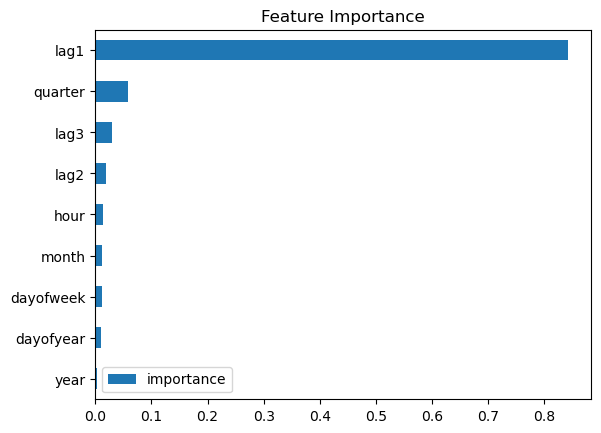

In [46]:
fi.sort_values('importance').plot(kind='barh', title = 'Feature Importance')
plt.show()

13. Calculate the predicted values and create a column for the values in the main dataframe. 

In [47]:
test['prediction'] = reg.predict(X_test)

In [48]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [49]:
df

,pm2_5,lag1,lag2,lag3,hour,dayofweek,quarter,month,year,dayofyear,prediction
date,,,,,,,,,,,
2020-12-01 05:00:00,9.31,NaN,NaN,NaN,5,1,4,12,2020,336,NaN
2020-12-01 06:00:00,8.43,9.31,NaN,NaN,6,1,4,12,2020,336,NaN
2020-12-01 07:00:00,8.55,8.43,9.31,NaN,7,1,4,12,2020,336,NaN
2020-12-01 08:00:00,8.92,8.55,8.43,9.31,8,1,4,12,2020,336,NaN
2020-12-01 09:00:00,9.62,8.92,8.55,8.43,9,1,4,12,2020,336,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,24.86,17.82,16.50,13,5,4,12,2022,365,27.883928
2022-12-31 14:00:00,45.75,36.08,24.86,17.82,14,5,4,12,2022,365,39.413700
2022-12-31 15:00:00,50.21,45.75,36.08,24.86,15,5,4,12,2022,365,43.854179


14. Visualize the predicted values versus the actual values. As you can see, the orange points seem to follow the lines of the actual values pretty closely. But, it looks like the model has issues predicting the big spikes, which you can see in the far right corner of the graph. 

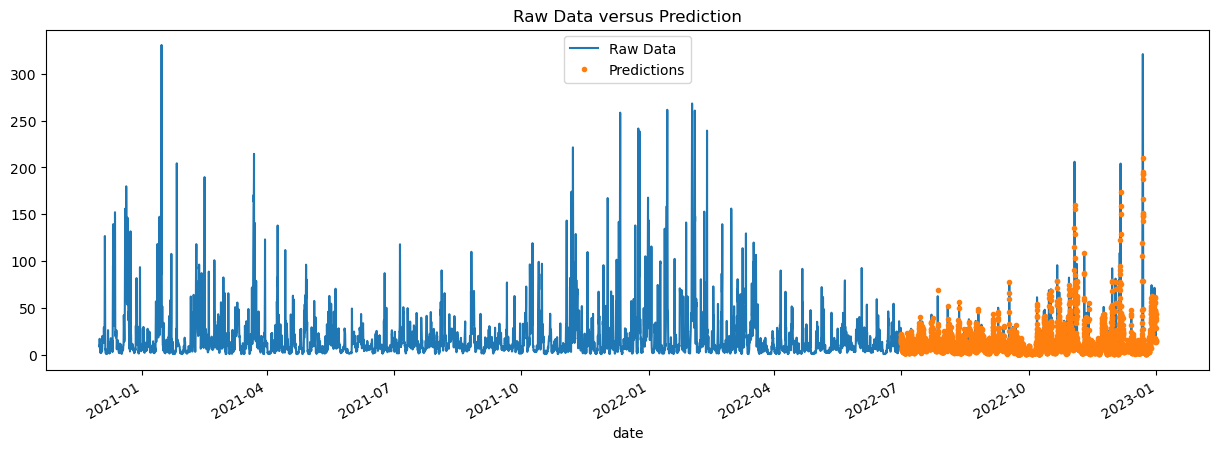

In [61]:
ax = df[['pm2_5']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Raw Data','Predictions'])
ax.set_title('Raw Data versus Prediction')
plt.show()

15. Calculate the Mean Squared Error. 

In [53]:
score = np.sqrt(mean_squared_error(test['pm2_5'],test['prediction']))
score 

6.37346800402881

16. Score the model for the training data, the number you get back is the coefficient of determination. The result was .94, which is close to 1, so the model did a good job of predicting values. 

In [57]:
trainScore = reg.score(X_train, y_train)
trainScore

0.941509497209909

17. Score the model for the testing data. The result was .90, so the model did not do as well on the testing data when compared to the training data, but the result is still relatively close to 1. 

In [58]:
testScore = reg.score(X_test, y_test)
testScore

0.9073472134736247

18. Save the model. 

In [59]:
from joblib import dump, load 

In [60]:
dump (reg, 'XGB_pm25.model')

['XGB_pm25.model']